## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from text import text_to_sequence
import scipy
from scipy.io.wavfile import write
from denoiser import Denoiser

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams.sampling_rate = 22050

#### Load model from checkpoint

In [4]:
checkpoint_path = "tacotron2_statedict.pt"
model = Tacotron2(hparams).cuda()
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [5]:
waveglow_path = 'waveglow_256channels.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

/home/kazuma/hdd/tacotron2/3.7-venv/lib/python3.7/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/kazuma/hdd/tacotron2/3.7-venv/lib/python3.7/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/kazuma/hdd/tacotron2/3.7-venv/lib/python3.7/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retr

#### Prepare text input

In [6]:
text = "Hello World!"
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

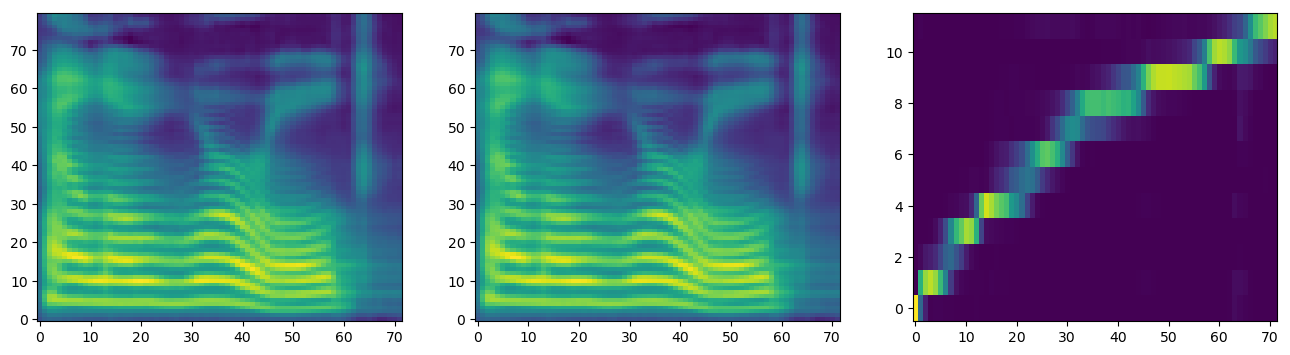

In [7]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [8]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

/home/kazuma/hdd/tacotron2/3.7-venv/lib/python3.7/site-packages/librosa/util/utils.py:724: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mag = np.abs(S).astype(np.float)


In [9]:
scipy.io.wavfile.write(filename='test.wav', rate=hparams.sampling_rate, data=audio[0].data.cpu().numpy())